In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from catboost import CatBoostClassifier, Pool

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv("features/emotion_features.csv")
df.head()


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-592.51970,55.269863,-19.240614,14.985034,-4.303793,-0.782968,-15.683035,-4.746463,-22.302803,-5.347614,...,-6.584931,-2.434462,-3.743652,-0.299833,1.267962,5.327147,3.982636,8.654726,11.515517,neutral
1,-571.77120,53.821240,-19.770304,14.672212,-3.221300,-2.219379,-15.660700,-4.115021,-21.762812,-0.923149,...,-6.433335,-2.461543,-4.143042,0.553830,1.998689,5.020371,4.224607,9.785756,11.845788,neutral
2,-579.21670,54.232810,-15.242693,17.250660,-4.751228,0.021345,-13.251750,-5.477705,-20.139534,-4.198607,...,-5.051621,-1.963996,-3.542640,-0.745385,1.221582,3.439566,5.602417,9.031712,9.748875,neutral
3,-581.09064,53.249720,-19.030127,17.035284,-5.648746,1.875090,-16.216503,-5.108720,-21.046432,-2.953222,...,-5.261818,-2.072452,-4.843049,0.880779,1.297034,4.160462,5.900162,9.407315,10.992938,neutral
4,-592.52057,61.175182,-16.242025,16.972326,-1.740968,-0.389398,-15.755614,-1.111939,-19.680891,-3.488038,...,2.623967,3.312066,-4.676119,-4.766972,-4.045164,1.991833,5.520200,10.280448,11.302134,calm


In [3]:
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))

Training samples: 1961
Validation samples: 491


In [4]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained!")

Model trained!


Overall Accuracy: 71.28%
Weighted F1 Score: 70.94%
Per-Class Accuracies:
angry: 84.00% accuracy
calm: 89.33% accuracy
disgust: 58.97% accuracy
fearful: 69.33% accuracy
happy: 62.67% accuracy
neutral: 60.53% accuracy
sad: 68.00% accuracy
surprised: 61.54% accuracy


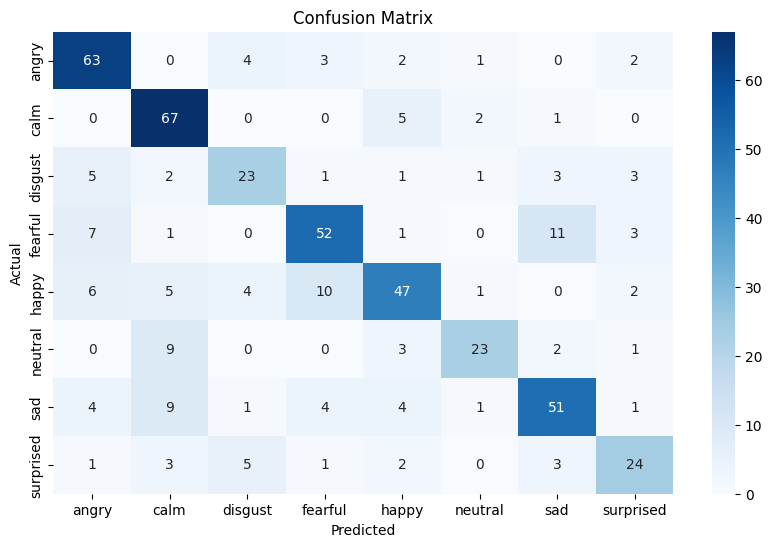

In [5]:
y_pred = model.predict(X_val)

overall_accuracy = accuracy_score(y_val, y_pred)
overall_f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Weighted F1 Score: {overall_f1 * 100:.2f}%")

report = classification_report(y_val, y_pred, output_dict=True)

print("Per-Class Accuracies:")
for label in model.classes_:
    class_acc = report[label]["recall"] * 100
    print(f"{label}: {class_acc:.2f}% accuracy")


cm = confusion_matrix(y_val, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [6]:

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [7]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_enc)

y_pred_enc = xgb_model.predict(X_val)

C:\Users\viren\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [8]:
y_pred = le.inverse_transform(y_pred_enc)


XGBoost Accuracy: 73.52 %
XGBoost F1 Score: 73.14 %
Per-Class Accuracies:
  angry: 88.00%
  calm: 93.33%
  disgust: 58.97%
  fearful: 70.67%
  happy: 69.33%
  neutral: 68.42%
  sad: 62.67%
  surprised: 61.54%


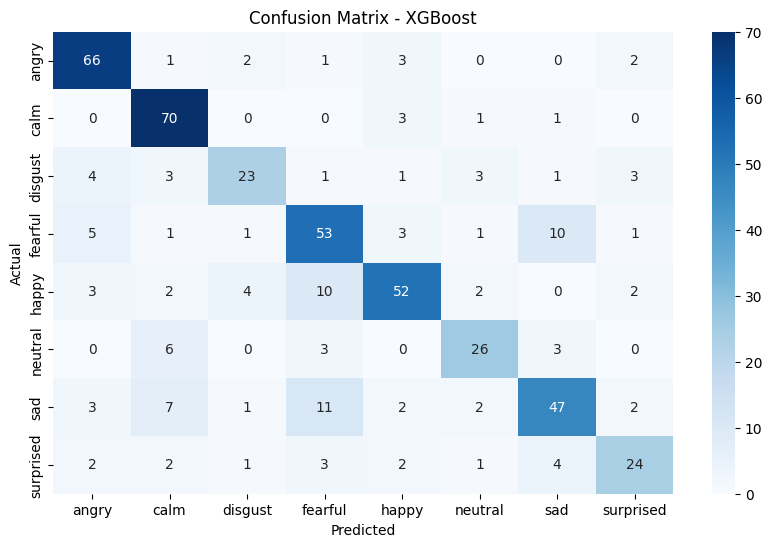

In [9]:
print("XGBoost Accuracy:", round(accuracy_score(y_val, y_pred) * 100, 2), "%")
print("XGBoost F1 Score:", round(f1_score(y_val, y_pred, average='weighted') * 100, 2), "%")

report = classification_report(y_val, y_pred, output_dict=True)
print("Per-Class Accuracies:")
for label in xgb_model.classes_:
    print(f"  {le.inverse_transform([label])[0]}: {report[le.inverse_transform([label])[0]]['recall']*100:.2f}%")

cm = confusion_matrix(y_val, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [10]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train_enc)

y_pred_enc = gb_model.predict(X_val)
y_pred = le.inverse_transform(y_pred_enc)

GB Accuracy: 61.3 %
GB F1 Score: 60.65 %
Per-Class Accuracies:
  angry: 77.33%
  calm: 82.67%
  disgust: 25.64%
  fearful: 61.33%
  happy: 53.33%
  neutral: 50.00%
  sad: 56.00%
  surprised: 61.54%


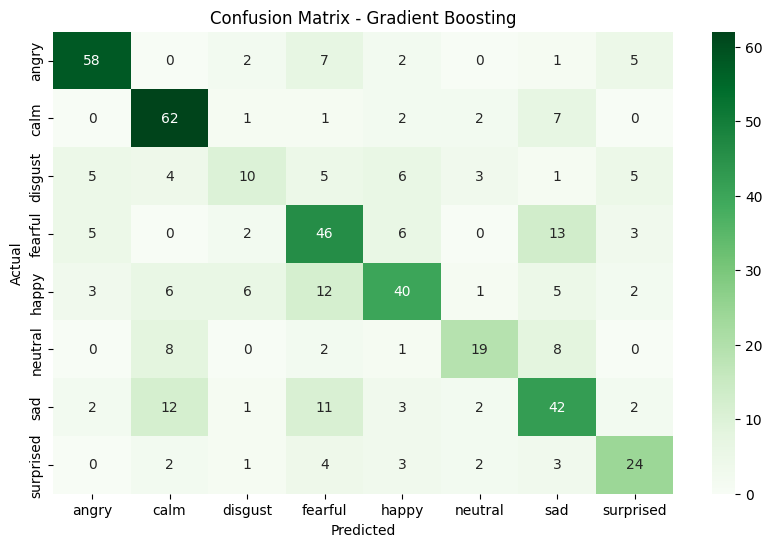

In [11]:
print("GB Accuracy:", round(accuracy_score(y_val, y_pred) * 100, 2), "%")
print("GB F1 Score:", round(f1_score(y_val, y_pred, average='weighted') * 100, 2), "%")

report = classification_report(y_val, y_pred, output_dict=True)
print("Per-Class Accuracies:")
for label in gb_model.classes_:
    print(f"  {le.inverse_transform([label])[0]}: {report[le.inverse_transform([label])[0]]['recall']*100:.2f}%")

cm = confusion_matrix(y_val, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

In [12]:
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))

svm_model.fit(X_train, y_train_enc)

y_pred_enc = svm_model.predict(X_val)
y_pred = le.inverse_transform(y_pred_enc)

SVM Accuracy: 67.62 %
SVM F1 Score: 67.2 %
Per-Class Accuracies:
  angry: 85.33%
  calm: 86.67%
  disgust: 53.85%
  fearful: 73.33%
  happy: 53.33%
  neutral: 50.00%
  sad: 56.00%
  surprised: 66.67%


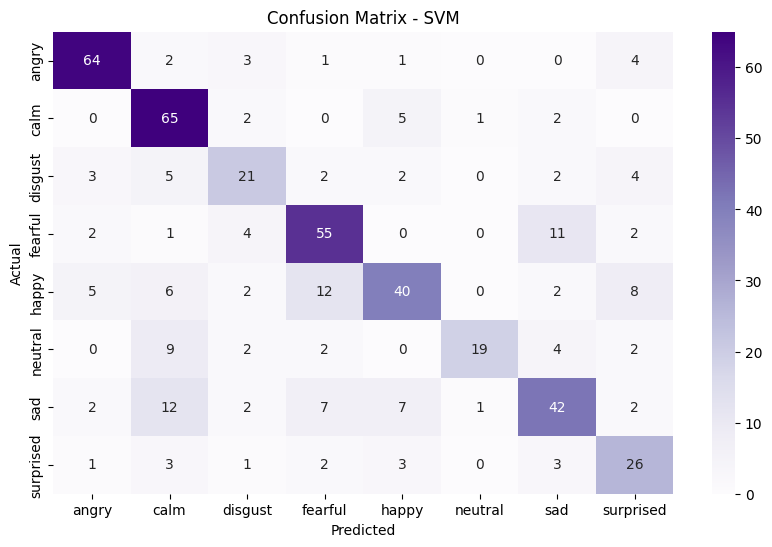

In [13]:
print("SVM Accuracy:", round(accuracy_score(y_val, y_pred) * 100, 2), "%")
print("SVM F1 Score:", round(f1_score(y_val, y_pred, average='weighted') * 100, 2), "%")

report = classification_report(y_val, y_pred, output_dict=True)
print("Per-Class Accuracies:")
for label in le.classes_:
    recall = report[label]["recall"] * 100
    print(f"  {label}: {recall:.2f}%")

cm = confusion_matrix(y_val, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Purples")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

In [15]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1, scoring='f1_weighted', verbose=1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\viren\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:52:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


Accuracy: 74.95 %
F1 Score: 74.65 %
Per-Class Accuracy:
  angry: 90.67%
  calm: 89.33%
  disgust: 58.97%
  fearful: 72.00%
  happy: 70.67%
  neutral: 68.42%
  sad: 66.67%
  surprised: 69.23%


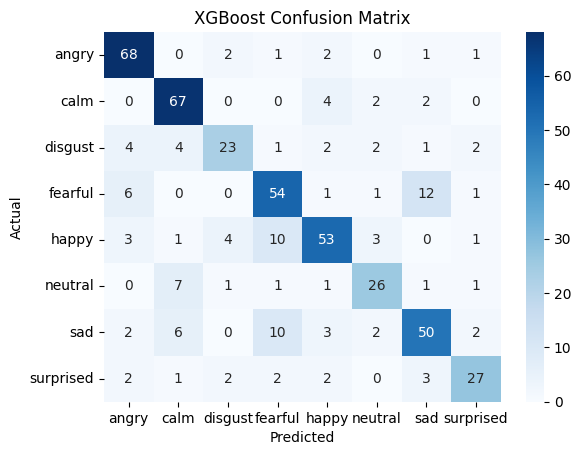

In [16]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_val)

print("Accuracy:", round(accuracy_score(y_val, y_pred)*100, 2), "%")
print("F1 Score:", round(f1_score(y_val, y_pred, average="weighted")*100, 2), "%")

print("Per-Class Accuracy:")
report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)

for label in le.classes_:
    print(f"  {label}: {report[label]['recall']*100:.2f}%")


cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 40
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -2.550772
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -2.570575
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -2.550772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM Results:
Accuracy: 74.13%
Weighted F1 Score: 73.59%
Per-Class Accuracy:
  angry: 86.67%
  calm: 93.33%
  disgust: 53.85%
  fearful: 73.33%
  happy: 73.33%
  neutral: 65.79%
  sad: 72.00%
  surpr

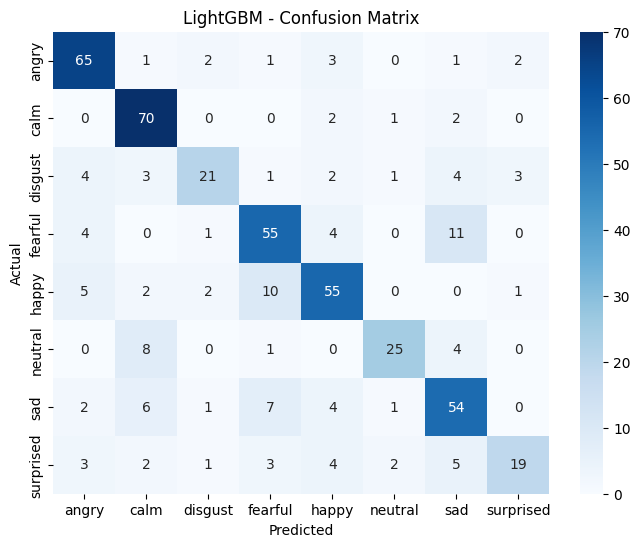


CatBoost Results:
Accuracy: 75.97%
Weighted F1 Score: 75.72%
Per-Class Accuracy:
  angry: 88.00%
  calm: 90.67%
  disgust: 58.97%
  fearful: 72.00%
  happy: 68.00%
  neutral: 73.68%
  sad: 69.33%
  surprised: 79.49%


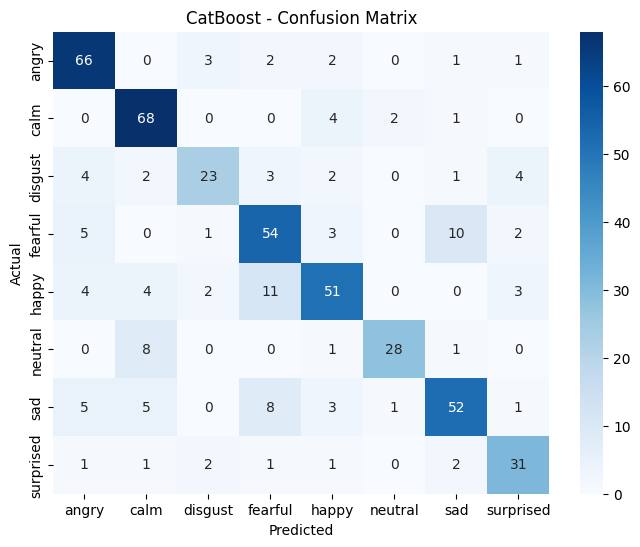


Voting Ensemble (RF + XGB + LGBM) Results:
Accuracy: 74.95%
Weighted F1 Score: 74.56%
Per-Class Accuracy:
  angry: 86.67%
  calm: 94.67%
  disgust: 58.97%
  fearful: 74.67%
  happy: 73.33%
  neutral: 65.79%
  sad: 66.67%
  surprised: 58.97%


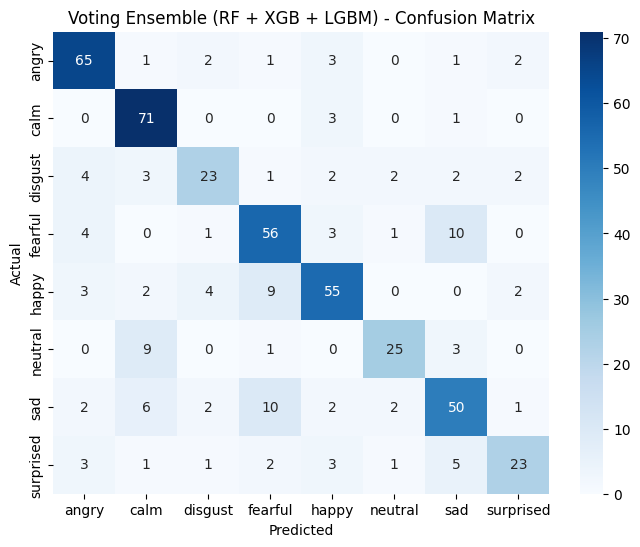

In [17]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Weighted F1 Score: {f1*100:.2f}%")

    
    report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)

    print("Per-Class Accuracy:")
    for label in le.classes_:
        recall = report[label]['recall']
        print(f"  {label}: {recall*100:.2f}%")

    
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

lgbm = LGBMClassifier(random_state=42)
evaluate_model(lgbm, "LightGBM")


catboost = CatBoostClassifier(verbose=0, random_state=42)
evaluate_model(catboost, "CatBoost")

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
], voting='soft', n_jobs=-1)

evaluate_model(ensemble, "Voting Ensemble (RF + XGB + LGBM)")


Accuracy: 62.12%
Weighted F1 Score: 61.48%
🔎 Per-Class Accuracy:
  angry: 86.67%
  calm: 76.00%
  disgust: 58.97%
  fearful: 33.33%
  happy: 50.67%
  neutral: 52.63%
  sad: 72.00%
  surprised: 58.97%


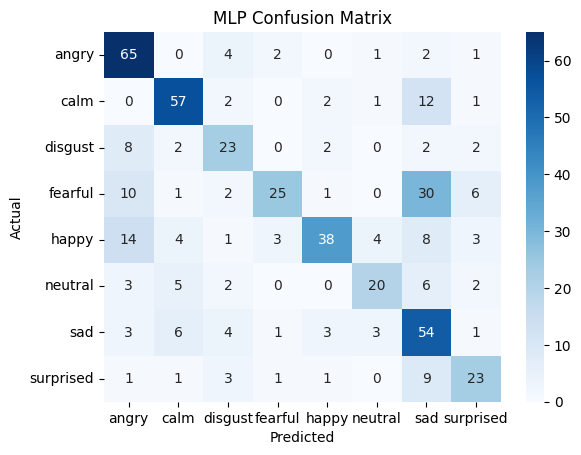

In [18]:
le = LabelEncoder()
y_enc = le.fit_transform(df["label"])
X = df.drop("label", axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

mlp = MLPClassifier(alpha=0.01, batch_size = 265, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_val)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {acc*100:.2f}%")
print(f"Weighted F1 Score: {f1*100:.2f}%")

report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)
print("🔎 Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report[label]['recall']*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy: 74.95%
_Weighted F1 Score: 74.63%
Per-Class Accuracy:
  angry: 86.67%
  calm: 93.33%
  disgust: 58.97%
  fearful: 73.33%
  happy: 73.33%
  neutral: 68.42%
  sad: 66.67%
  surprised: 61.54%


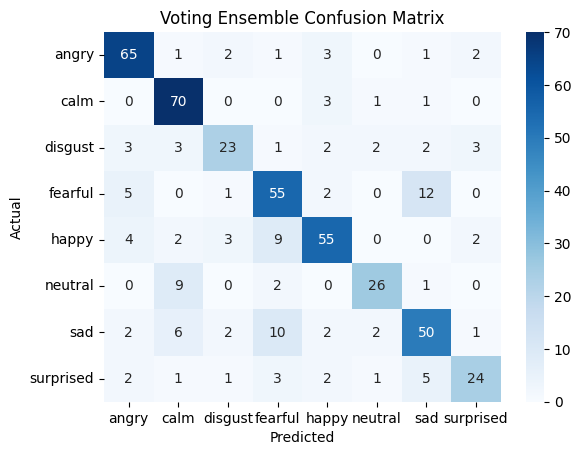

In [19]:
le = LabelEncoder()
y_enc = le.fit_transform(df["label"])
X = df.drop("label", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

cat_model = CatBoostClassifier(verbose=0, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

ensemble = VotingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('xgboost', xgb_model),
        ('lightgbm', lgbm_model)
    ],
    voting='soft',  # Use predicted probabilities
    n_jobs=-1
)

# Step 5: Train
ensemble.fit(X_train, y_train)

# Step 6: Predict and Evaluate
y_pred = ensemble.predict(X_val)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {acc * 100:.2f}%")
print(f"_Weighted F1 Score: {f1 * 100:.2f}%")

report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)
print("Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report[label]['recall']*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Voting Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()